In [4]:
import os
!pip install fasttext
import fasttext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET
from IPython.display import clear_output
import tensorflow as tf

!pip install nltk
import nltk
nltk.download('punkt')
clear_output()

if not os.path.exists("articles/"):
  !wget https://zenodo.org/record/1239675/files/articles.zip?download=1 -O articles.zip
  !unzip articles.zip
  !rm articles.zip
  clear_output()
  print("Data successfully downloaded")
else:
  print("Data already downloaded")


random_seed = 176249

Data already downloaded


In [29]:
def read_data(test_size=0.2,random_state=0):
  data = {
      # "author": [],
      # "title": [],
      "mainText": [],
      "orientation": [],
      # "veracity": []
  }
  index = []
  for filename in os.listdir("articles/"):
    root = ET.parse(f"articles/{filename}").getroot()
    index.append(int(filename.split(".")[0]))
    for elem in root:
      if elem.tag in data.keys():
        data[elem.tag].append(elem.text)
  data = pd.DataFrame(data,index=index)
  data = data[data.notna().all(axis="columns")]
  data = data.sample(frac=1,random_state=random_state)
  N = len(data)
  train_split, test_split = data.iloc[int(N*test_size):,:], data.iloc[:int(N*test_size),:]
  train_split = train_split.reset_index(drop=True)
  test_split = test_split.reset_index(drop=True)
  return train_split, test_split
  
train_split, test_split = read_data(test_size=0.2,random_state=random_seed)

In [30]:
def normalize_text(corpus,stop_words=None):

  # Convierto a lowercase
  corpus_lower = corpus.str.lower()

  # Elimino signos de puntuación, caracteres raros, etc.
  normalized_corpus = corpus_lower.str.replace(r"[^\w\d\s]+","",regex=True)

  # Elimino los stopwords
  if stop_words is not None:
    stop_words = "|".join(stop_words)
    normalized_corpus = normalized_corpus.str.replace(stop_words,"",regex=True)

  # Elimino espacios innecesarios
  normalized_corpus = normalized_corpus.str.replace(r"\s+"," ",regex=True)

  return normalized_corpus

train_data, test_data = read_data(test_size=0.2,random_state=random_seed)
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=None)
train_data

,mainText,orientation
0,its no coincidence donald trump rolled out his...,mainstream
1,an allegedly unarmed mentally disabled black m...,left
2,house speaker paul ryan is facing a major obst...,mainstream
3,mike pence defended his running mate donald tr...,mainstream
4,its prospects are far from clear but talk abou...,mainstream
...,...,...
1279,republican national committee chairman reince ...,left
1280,as the presidential campaign enters its home s...,mainstream
1281,greensboro north carolina cnndonald trump decl...,mainstream
1282,the city of flint michigan is suffering throug...,left


In [113]:
X_left = train_split.loc[train_split['orientation'] == 'left', :]
X_right = train_split.loc[train_split['orientation'] == 'right', :]

In [38]:
if not os.path.exists("cc.en.300.bin"):
  !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
  !gzip -d cc.en.300.bin.gz

--2022-09-27 14:28:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  36.7MB/s    in 1m 58s  

2022-09-27 14:30:50 (36.3 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [39]:
model = fasttext.load_model('cc.en.300.bin')

In [43]:
from nltk import word_tokenize
from collections import defaultdict
# grafico las palabras para ver las frecuencias
def create_vocabulary(corpus,tokenizer,max_tokens=40000,min_freq=1):
  counts = defaultdict(lambda: 0)
  for comment in tqdm(corpus):
    for token in tokenizer(comment):
      counts[token] += 1

  valid_tokens = sorted([tk for tk in counts.keys() if counts[tk] >= min_freq],key=counts.get,reverse=True)[:max_tokens]
  counts = [counts[tk] for tk in valid_tokens]
  return pd.Series(counts,index=valid_tokens)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 204/204 [00:00<00:00, 819.18it/s]


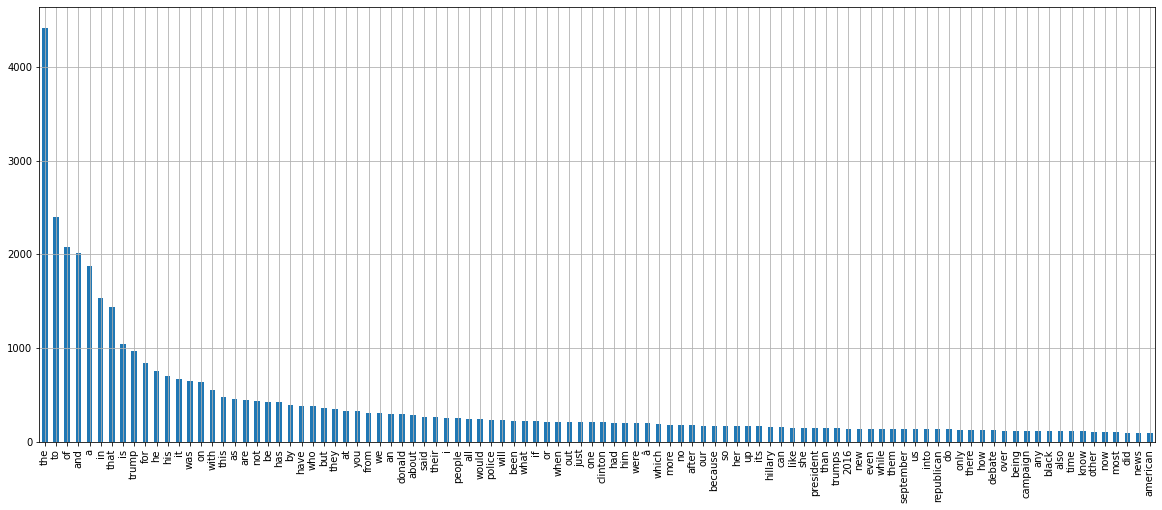

In [125]:
X_left["mainText"] = normalize_text(X_left["mainText"],stop_words=[])
vocab_left = create_vocabulary(X_left["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab_left[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 424/424 [00:00<00:00, 859.60it/s]


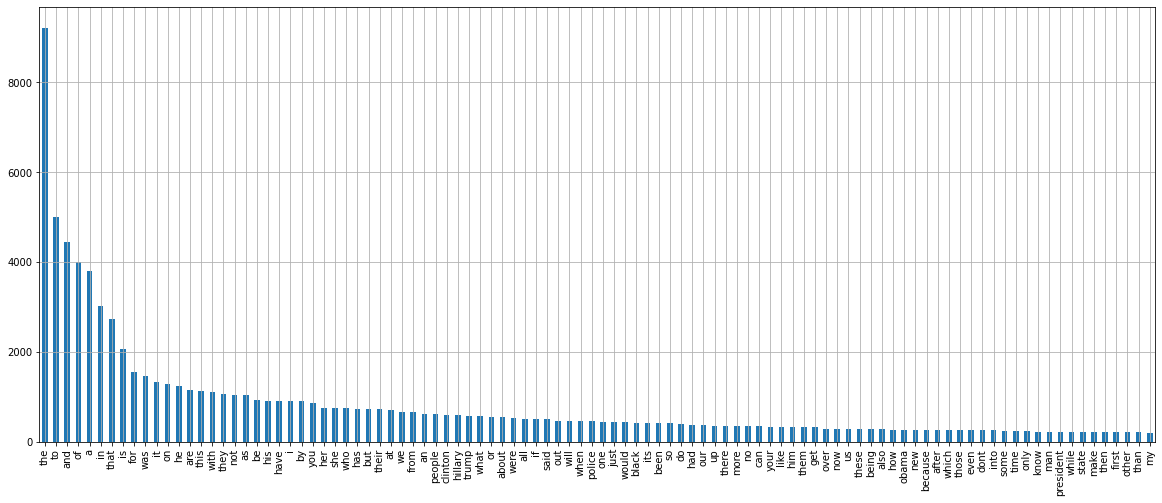

In [126]:
X_right["mainText"] = normalize_text(X_right["mainText"],stop_words=[])
vocab_right = create_vocabulary(X_right["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab_right[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

In [127]:
words_to_be_plotted = [
  "people", "hillary", "trump", "police", "black",
  "american", "country", "government", "email", "officers",
  "reported", "charlotte", "family", "men", "gun",
  "died", "voters", "muslim", "support", "republican"
]

In [130]:
# Obtenemos la matriz de word embeddings
word_embeddings_matrix_left = np.vstack([model[word] for word in vocab_left.keys()])
print("Matrix shape:",word_embeddings_matrix_left.shape)

word_embeddings_matrix_right = np.vstack([model[word] for word in vocab_right.keys()])
print("Matrix shape:",word_embeddings_matrix_right.shape)

Matrix shape: (2237, 300)
Matrix shape: (3668, 300)


In [131]:
from sklearn import decomposition

def plot_words2d(word_embeddings_matrix,words_to_be_plotted,x_lim=None,y_lim=None):
  """
  Función para graficar los vectores en dos dimensiones.

  Args:
    - word_embeddings_matrix: numpy.array de dimensión (n x d) con las
    representaciones de las palabras. (n = cantidad de palabras, d = dimensión
    de los vectores.)
    - words_to_be_plotted: lista de palabras correspondientes a las filas de la 
    matriz word_embeddings_matrix.
    - x_lim: tupla (float, float) con los límites del gráfico en la direción del 
    eje x.
    - y_lim: tupla (float, float) con los límites del gráfico en la direción del 
    eje y.

  """

  # Extraigo las primeras 2 componentes principales
  pca = decomposition.PCA(n_components=2)
  pca.fit(word_embeddings_matrix)
  words_to_be_plotted_casted = np.vstack([model[word] for word in words_to_be_plotted])
  principals = pca.transform(words_to_be_plotted_casted)

  # Si los límites son None, los seteo para inluir a todas las representaciones.
  if not x_lim:
    x_lim = (principals[:,0].min()*1.1, principals[:,0].max()*1.1)
  if not y_lim:
    y_lim = (principals[:,1].min()*1.1, principals[:,1].max()*1.1)

  # Grafico los puntos
  fig, ax = plt.subplots(1,1,figsize=(12,12))
  ax.plot(principals[:,0],principals[:,1],"o",ms=3)

  # Anoto las palabras
  for i, word in enumerate(words_to_be_plotted):
    if principals[i,0] <= x_lim[0] or principals[i,1] <= y_lim[0] or \
      principals[i,0] >= x_lim[1] or principals[i,1] >= y_lim[1]:
        continue
    ax.text(principals[i,0]*1.001,principals[i,1]*1.001,word,fontsize=15)

  ax.grid(True)
  ax.set_xlim(*x_lim)
  ax.set_ylim(*y_lim)
  fig.tight_layout()

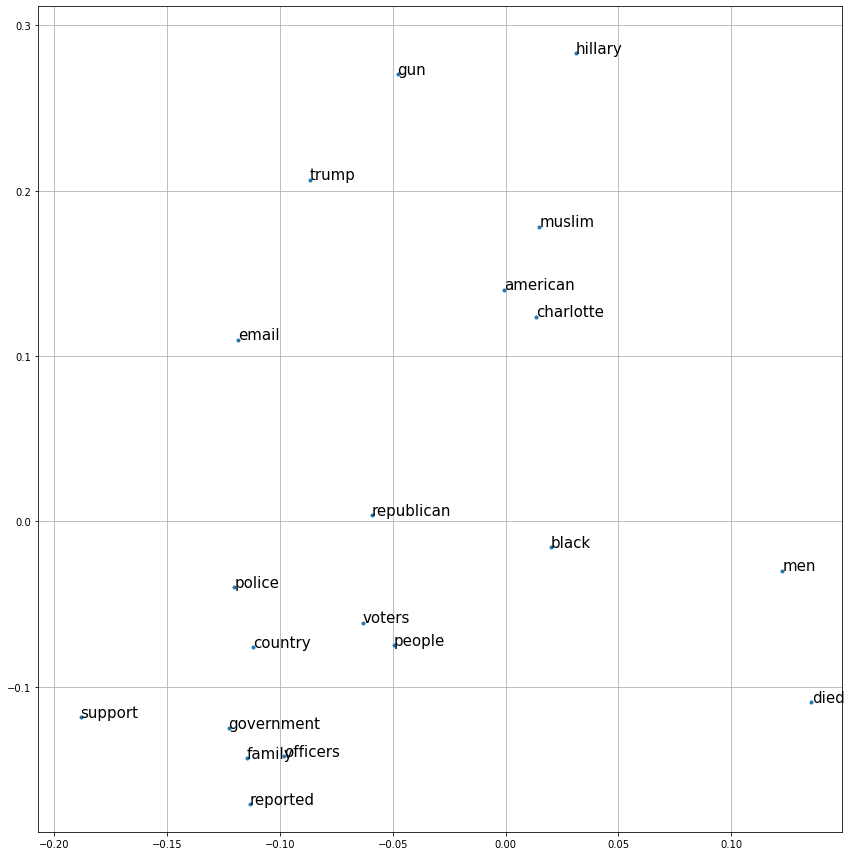

In [132]:
x_lim = None
y_lim = None
plot_words2d(word_embeddings_matrix_left,words_to_be_plotted,x_lim,y_lim)

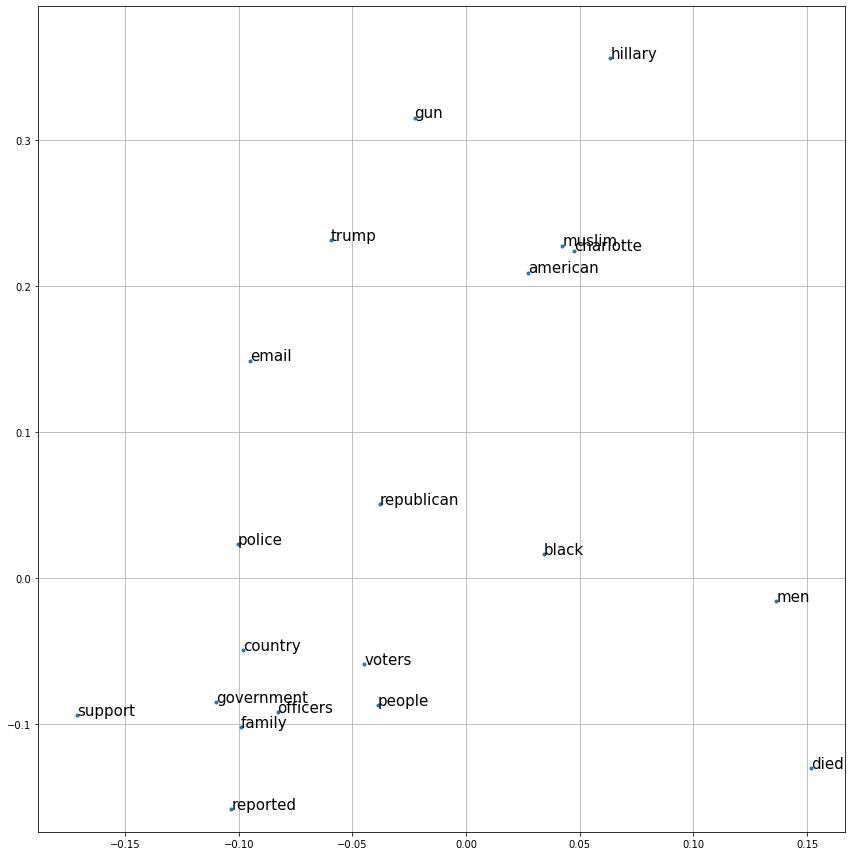

In [133]:
x_lim = None
y_lim = None
plot_words2d(word_embeddings_matrix_right,words_to_be_plotted,x_lim,y_lim)